In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.9.0


In [3]:
df = pd.DataFrame(
    data={'date': pd.date_range(start='2018-01-01', end='2020-06-30', freq='D')}
)

n = df.shape[0]

In [4]:
np.random.seed(seed=42)

df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df['x'] = 0.0 # np.random.uniform(low=0.0, high=1.0, size=n)

df['y'] = df['x'] \
    + (0.8)*df['x'].shift(1) \
    + np.power(df.index.values, 1/3) \
    + 2*np.sin(2*np.pi*df['month']/12) \
    + np.cos(2*np.pi*df['day_of_month']/30) \
    + np.random.normal(loc=0.0, scale=0.3, size=n)

df['y'] = df['y'].fillna(method='backfill')

df.head()

,date,day_of_month,month,year,x,y
0,2018-01-01,1,1,2018,0.0,2.872066
1,2018-01-02,2,1,2018,0.0,2.872066
2,2018-01-03,3,1,2018,0.0,3.263245
3,2018-01-04,4,1,2018,0.0,3.568289
4,2018-01-05,5,1,2018,0.0,3.017155


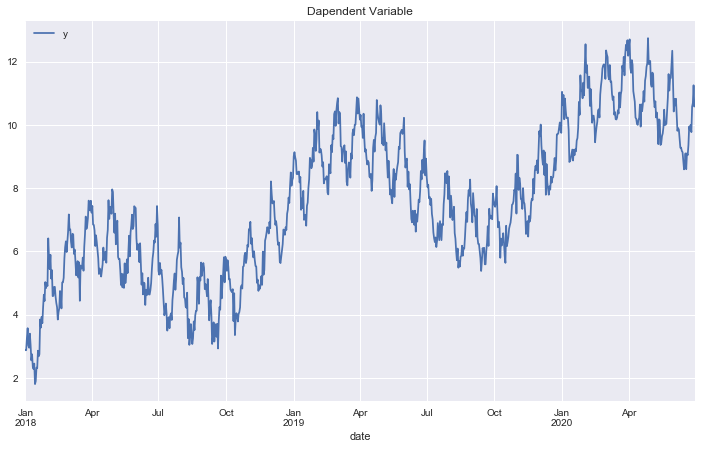

In [5]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
df.plot(x='date', y='y', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

In [6]:
df_train = df.query('year < 2020')
df_test = df.query('year > 2019')

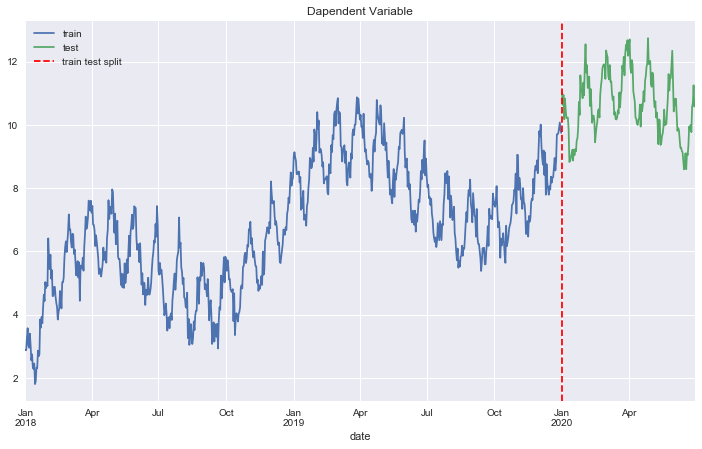

In [7]:
fig, ax = plt.subplots()
df_train.plot(x='date', y='y', label='train', ax=ax)
df_test.plot(x='date', y='y', label='test', ax=ax)
ax.axvline('2020-01-1', color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

In [8]:
trend = tfp.sts.LocalLinearTrend(observed_time_series=df_train['y'])
seasonal_month = tfp.sts.Seasonal(
    num_seasons=30, 
    observed_time_series=df_train['y'], 
    name='monthly'
)

seasonal_year = tfp.sts.Seasonal(
    num_seasons=12,
    num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], 
    observed_time_series=df_train['y'], 
    name='yearly'
)
toy_model = tfp.sts.Sum([trend, seasonal_month, seasonal_year], observed_time_series=df_train['y'])

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [9]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


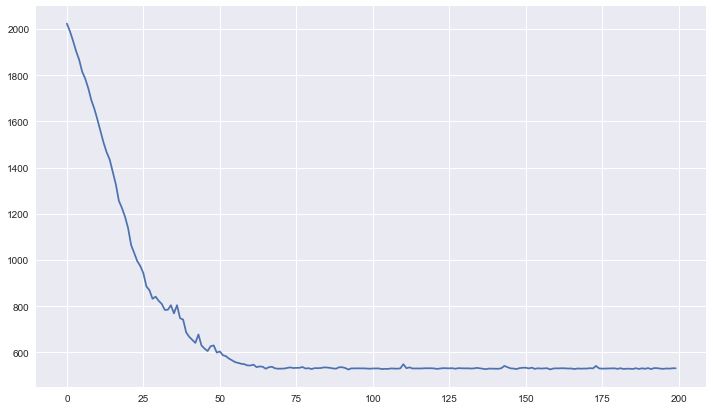

In [10]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=toy_model.joint_log_prob(
        observed_time_series=df_train['y']),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
    return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_co2_ = variational_posteriors.sample(50)

In [11]:
print("Inferred parameters:")
for param in toy_model.parameters:
      print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_co2_[param.name], axis=0),
                              np.std(q_samples_co2_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.28397514190009526 +- 0.008202276560751526
LocalLinearTrend/_level_scale: 0.03501025514808213 +- 0.04331468287555018
LocalLinearTrend/_slope_scale: 0.04951222628298629 +- 0.004574147547951039
monthly/_drift_scale: 0.022567134471409046 +- 0.017665935907682766
yearly/_drift_scale: 0.007618334804759422 +- 0.012723867776979076


In [12]:
co2_forecast_dist = tfp.sts.forecast(
    toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples_co2_,
    num_steps_forecast=182)

In [13]:
num_samples=10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples).numpy()[..., 0])

In [14]:
co2_forecast_mean

array([10.56061295, 10.63229995, 10.64412781, 10.52814075, 10.61055026,
       10.64659968, 10.60039557, 10.90223241, 10.95956718, 11.10855309,
       11.41185515, 11.60742517, 11.76514377, 12.24824444, 12.56235708,
       12.81078487, 13.11419156, 13.441014  , 13.87331561, 14.20489691,
       14.41934891, 14.65625731, 14.78583037, 15.12724675, 15.15637445,
       15.28354517, 15.38611376, 15.39475624, 15.38291373, 15.44730847,
       15.4233806 , 16.30996881, 16.32179666, 16.20580961, 16.28821911,
       16.32426854, 16.27806443, 16.57990127, 16.63723604, 16.78622195,
       17.089524  , 17.28509403, 17.44281263, 17.9259133 , 18.24002594,
       18.48845373, 18.79186042, 19.11868286, 19.55098447, 19.88256577,
       20.09701777, 20.33392617, 20.46349923, 20.80491561, 20.83404331,
       20.96121403, 21.06378262, 21.0724251 , 21.06058259, 21.29514458,
       21.27121671, 21.34290372, 21.35473157, 21.23874452, 21.32115402,
       21.35720345, 21.31099933, 21.61283617, 21.67017094, 21.81

In [15]:
df_test['pred'] = co2_forecast_mean.copy()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


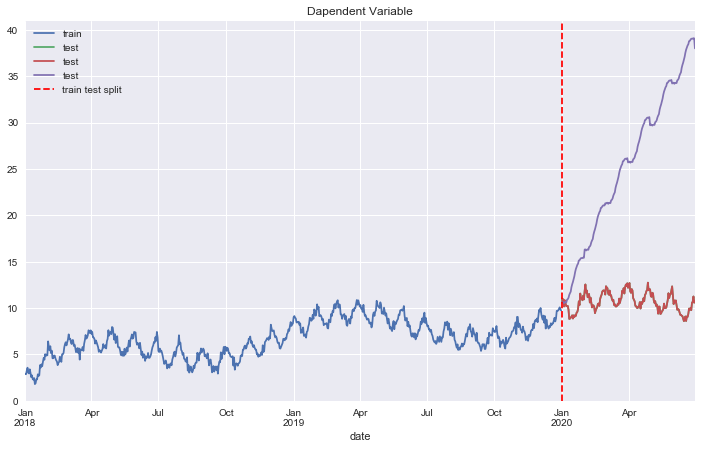

In [16]:
fig, ax = plt.subplots()
df_train.plot(x='date', y='y', label='train', ax=ax)
df_test.plot(x='date', y='y', label='test', ax=ax)
df_test.plot(x='date', y='y', label='test', ax=ax)
df_test.plot(x='date', y='pred', label='test', ax=ax)
ax.axvline('2020-01-1', color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');